In [1]:
%pip install -q -U tensorflow matplotlib tensorflow_hub keras scipy mlflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf


In [3]:
import os

DATA_DIR  = 'data'
for dirpath, dirnames, filenames in os.walk(DATA_DIR):
    print(f"There are {len(filenames)}  directories and {len(filenames)} images in '{dirpath}'.")

There are 0  directories and 0 images in 'data'.
There are 0  directories and 0 images in 'data\testing'.
There are 44  directories and 44 images in 'data\testing\blue'.
There are 12  directories and 12 images in 'data\testing\brown'.
There are 10  directories and 10 images in 'data\testing\green'.
There are 16  directories and 16 images in 'data\testing\orange'.
There are 35  directories and 35 images in 'data\testing\yellow'.
There are 0  directories and 0 images in 'data\training'.
There are 1046  directories and 1046 images in 'data\training\blue'.
There are 973  directories and 973 images in 'data\training\brown'.
There are 1050  directories and 1050 images in 'data\training\green'.
There are 1049  directories and 1049 images in 'data\training\orange'.
There are 1439  directories and 1439 images in 'data\training\yellow'.


In [4]:

import pathlib
import numpy as np
data_dir = pathlib.Path(DATA_DIR+'/training')
class_names = np.array(sorted([ite.name for ite in data_dir.glob('*')]))
print(class_names)

['blue' 'brown' 'green' 'orange' 'yellow']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (225, 225, 3)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

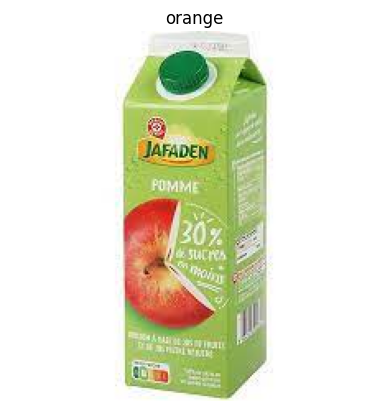

In [6]:
view_random_image(DATA_DIR+'/training/', "orange")

In [21]:

import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


tf.random.set_seed(42)

def remove_alpha_channel(img):
    if img.shape[-1] == 4:
      
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.convert("RGB")
        img = np.array(img) / 255.0  # נורמליזציה מחדש
    return img



IMAGE_SIZE = (299, 299)
training_data_dir = DATA_DIR + '/training'
testing_data_dir = DATA_DIR + '/testing'

testing_gen = ImageDataGenerator(rescale=1./255,
                              preprocessing_function=remove_alpha_channel)




train_datagen_augmented = ImageDataGenerator(
                                             rescale=1./255,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             brightness_range=[0.8, 1.5],
                                             preprocessing_function=remove_alpha_channel,
                                             horizontal_flip=True)


train_data = train_datagen_augmented.flow_from_directory(training_data_dir,
                                batch_size = 32,
                                target_size=IMAGE_SIZE, # convert all images to be 224 x 224
                                class_mode="categorical", # type of problem we're working on
                                seed=42)


test_data = testing_gen.flow_from_directory(testing_data_dir,
                                batch_size = 32,
                                target_size=IMAGE_SIZE, # convert all images to be 224 x 224
                                class_mode="categorical", # type of problem we're working on
                                seed=42)


 

Found 5550 images belonging to 5 classes.
Found 117 images belonging to 5 classes.


In [22]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10, image_shape=IMAGE_SIZE):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer2',
                                           input_shape=image_shape+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(units=num_classes, activation="softmax", name='output_layer') # create our own output layer      
  ])

  return model

In [23]:
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam( learning_rate=0.05),
                     metrics=['accuracy'])

In [24]:
import mlflow

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("mlflow-tf-keras-mnist+3")

mlflow.tensorflow.autolog()


with mlflow.start_run():
    resnet_model.fit(train_data,
                        epochs=3,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

2025/03/25 11:04:03 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/03/25 11:04:03 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/3


c:\Users\nir.morad\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


174/174 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.9396

c:\Users\nir.morad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


174/174 [==============================] - 419s 2s/step - loss: 0.8164 - accuracy: 0.9396 - val_loss: 4.5124 - val_accuracy: 0.7863
Epoch 2/3
174/174 [==============================] - 399s 2s/step - loss: 0.5312 - accuracy: 0.9737 - val_loss: 8.7983 - val_accuracy: 0.7265
Epoch 3/3
174/174 [==============================] - 391s 2s/step - loss: 0.4603 - accuracy: 0.9778 - val_loss: 10.8621 - val_accuracy: 0.7265


2025/03/25 11:24:14 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/03/25 11:24:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\NIR~1.MOR\AppData\Local\Temp\tmpoaimjei3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\NIR~1.MOR\AppData\Local\Temp\tmpoaimjei3\model\data\model\assets
2025/03/25 11:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dazzling-eel-614 at: http://127.0.0.1:8080/#/experiments/977800066742973464/runs/46daf6c37ab2493698048baefdc4099c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/977800066742973464


In [28]:
preds  = resnet_model.predict(test_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_pred
# התוויות האמיתיות
y_true = test_data.classes
y_true

4/4 [==============================] - 14s 3s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4])

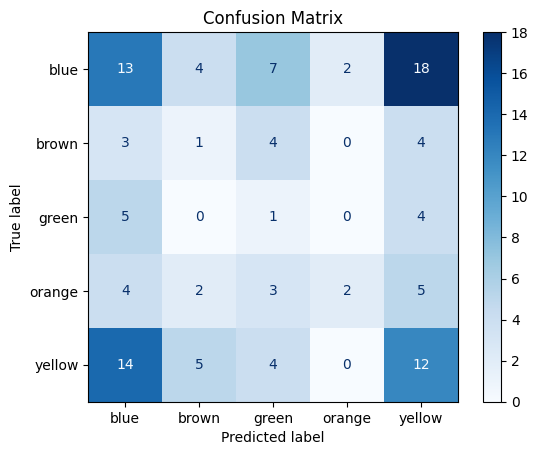

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# שמות הקטגוריות
class_names = list(test_data.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
